In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.interpolate import CubicSpline

In [77]:
df=pd.read_excel('full_gefira_hourly.xlsx')
# Convert 'datetime' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'datetime' as the index
df.set_index('Date', inplace=True)
numeric_columns = ['Water Level','Streamflow','Precipitation','Tmean','Tmin','Tmax','SolRad','Pmean','windSp']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Step 1: Drop rows with NAs for interpolation
df_interp = df.dropna()

# Step 2: Create a cubic spline interpolation function for each column
for column in df.columns:
    if df[column].isna().sum() > 0:
        cs = CubicSpline(df_interp.index, df_interp[column], bc_type='natural')
        df[column] = cs(df.index)
print('Successfully added missing values with spline interpolation')
print("NaN values in dataframe ")
print( df.isna().sum())
# Create a boolean mask for NaN values
nan_mask = df.isna()

# Get the indices where NaN values are present
nan_indices = df.index[nan_mask.any(axis=1)].tolist()

print("Indices with NaN values:", nan_indices)
# Generate a complete date range from the minimum to maximum date in the DataFrame
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

# Find the missing dates by subtracting the existing dates from the complete date range
missing_dates = complete_date_range.difference(df.index)

# Print or display the missing dates
print("Missing dates:", missing_dates)

Successfully added missing values with spline interpolation
NaN values in dataframe 
Water Level      0
Streamflow       0
Tmean            0
Tmin             0
Tmax             0
SolRad           0
Pmean            0
Precipitation    0
windSp           0
dtype: int64
Indices with NaN values: []
Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [78]:
df.head()

,Water Level,Streamflow,Tmean,Tmin,Tmax,SolRad,Pmean,Precipitation,windSp
Date,,,,,,,,,
2017-07-04 14:00:00,41.0,1520.20,13.583333,13.0,14.0,0.0,0.0,0.0,0.0
2017-07-04 15:00:00,41.0,1520.20,13.850000,13.5,14.7,0.0,0.0,0.0,0.0
2017-07-04 16:00:00,41.0,1520.20,14.150000,13.9,14.4,1.7,0.0,0.0,0.0
2017-07-04 17:00:00,40.0,1448.66,14.250000,14.2,14.3,0.0,0.0,0.0,0.0
2017-07-04 18:00:00,42.0,1593.42,14.266667,14.1,14.4,0.0,0.0,0.0,0.0


In [ ]:
# Hydrological indices for model evaluation
# Values >0.75 show good fit
def calculate_nse(y_observed, y_predicted):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE).

    Parameters:
    - y_observed: Observed streamflow values
    - y_predicted: Predicted streamflow values

    Returns:
    - nse: Nash-Sutcliffe Efficiency
    """
    mean_observed = np.mean(y_observed)
    nse = 1 - np.sum((y_observed - y_predicted)**2) / np.sum((y_observed - mean_observed)**2)
    return nse


def calculate_kge(y_observed, y_predicted):
    """
    Calculate Kling–Gupta Efficiency (KGE).

    Parameters:
    - y_observed: Observed streamflow values
    - y_predicted: Predicted streamflow values

    Returns:
    - kge: Kling–Gupta Efficiency
    """
    mean_observed = np.mean(y_observed)
    mean_simulated = np.mean(y_predicted)

    std_observed = np.std(y_observed)
    std_simulated = np.std(y_predicted)

    correlation = np.corrcoef(y_observed, y_predicted)[0, 1]

    kge = 1 - np.sqrt((correlation - 1)**2 + (std_simulated/std_observed - 1)**2 + (mean_simulated/mean_observed - 1)**2)
    return kge


# # Example usage:
# y_observed = y_test
# y_predicted = model.predict(X_test).flatten()

# nse_result = calculate_nse(y_observed, y_predicted)
# kge_result = calculate_kge(y_observed, y_predicted)

# print(f'Nash-Sutcliffe Efficiency (NSE): {nse_result}')
# print(f'Kling–Gupta Efficiency (KGE): {kge_result}')


In [16]:
# Function to create lagged columns for specified features
def create_lagged_features(df, features, lag_periods):
    for feature in features:
        for lag in lag_periods:
            df[f'{feature}_Lag{lag}'] = df[feature].shift(lag)
    return df.dropna()

# Function to split data into training and testing sets
def split_data(df, split_date):
    train_data = df[df.index <= split_date]
    test_data = df[df.index > split_date]
    return train_data, test_data

# Function to prepare input data for LSTM
def prepare_lstm_data(df, features, lag_periods, target_feature):
    lagged_features = [f'{feature}_Lag{lag}' for feature in features for lag in lag_periods]
    X = df[features + lagged_features].values
    Y = df[target_feature].values
    return X, Y
# Function to prepare input data for LSTM
def prepare_lstm_data(df, features, lag_periods, target_feature):
    lagged_features = [f'{feature}_Lag{lag}' for feature in features for lag in lag_periods]
    print(lagged_features)
    X = df[lagged_features].values
    Y = df[target_feature].values
    return X, Y
# Function to standardize data
def standardize_data(X_train, X_test, y_train, y_test):
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1))

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_Y

# Function to reshape input data for LSTM
def reshape_for_lstm(X_train_scaled, X_test_scaled):
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    return X_train_reshaped, X_test_reshaped

# Function to build and train LSTM model
def build_and_train_lstm(X_train_reshaped, y_train_scaled, epochs, batch_size=32):
    model = Sequential()
    model.add(LSTM(10, activation='tanh', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return model

def evaluate_and_plot(model, X_test_reshaped, y_test_scaled, scaler_Y):
    y_pred_scaled = model.predict(X_test_reshaped)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled)

    # Inverse transform the actual values for comparison
    y_test_inverse = scaler_Y.inverse_transform(y_test_scaled)

    # Flatten the arrays for compatibility with NSE and KGE calculations
    y_test_flatten = y_test_inverse.flatten()
    y_pred_flatten = y_pred.flatten()

    # Calculate Nash-Sutcliffe Efficiency (NSE)
    nse = calculate_nse(y_test_flatten, y_pred_flatten)

    # Calculate Kling–Gupta Efficiency (KGE)
    kge = calculate_kge(y_test_flatten, y_pred_flatten)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inverse, label='Actual Streamflow', color='blue')
    plt.plot(y_pred, label='Predicted Streamflow', color='red', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Streamflow')
    plt.title(f'LSTM Streamflow Prediction\nNSE: {nse:.4f}, KGE: {kge:.4f}')
    plt.legend()
    plt.show()

    print(f'Nash-Sutcliffe Efficiency (NSE): {nse:.4f}')
    print(f'Kling–Gupta Efficiency (KGE): {kge:.4f}')


['Precipitation_Lag24', 'Precipitation_Lag48', 'Precipitation_Lag72', 'Precipitation_Lag168', 'Precipitation_Lag336', 'Tmean_Lag24', 'Tmean_Lag48', 'Tmean_Lag72', 'Tmean_Lag168', 'Tmean_Lag336', 'Tmin_Lag24', 'Tmin_Lag48', 'Tmin_Lag72', 'Tmin_Lag168', 'Tmin_Lag336', 'Tmax_Lag24', 'Tmax_Lag48', 'Tmax_Lag72', 'Tmax_Lag168', 'Tmax_Lag336', 'SolRad_Lag24', 'SolRad_Lag48', 'SolRad_Lag72', 'SolRad_Lag168', 'SolRad_Lag336', 'windSp_Lag24', 'windSp_Lag48', 'windSp_Lag72', 'windSp_Lag168', 'windSp_Lag336', 'Streamflow_Lag24', 'Streamflow_Lag48', 'Streamflow_Lag72', 'Streamflow_Lag168', 'Streamflow_Lag336']
['Precipitation_Lag24', 'Precipitation_Lag48', 'Precipitation_Lag72', 'Precipitation_Lag168', 'Precipitation_Lag336', 'Tmean_Lag24', 'Tmean_Lag48', 'Tmean_Lag72', 'Tmean_Lag168', 'Tmean_Lag336', 'Tmin_Lag24', 'Tmin_Lag48', 'Tmin_Lag72', 'Tmin_Lag168', 'Tmin_Lag336', 'Tmax_Lag24', 'Tmax_Lag48', 'Tmax_Lag72', 'Tmax_Lag168', 'Tmax_Lag336', 'SolRad_Lag24', 'SolRad_Lag48', 'SolRad_Lag72', 'SolRad_

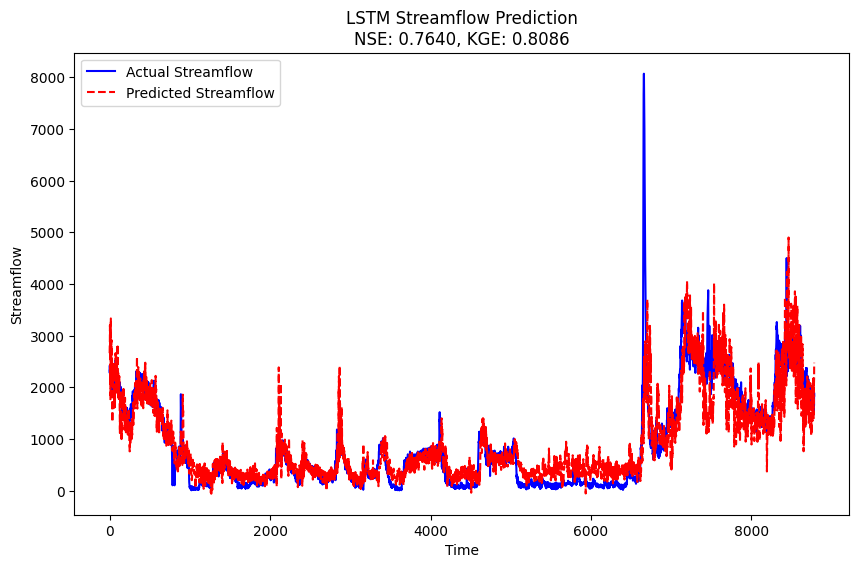

Nash-Sutcliffe Efficiency (NSE): 0.7640
Kling–Gupta Efficiency (KGE): 0.8086


In [22]:
# Set lag periods
lag_periods = [24,48,72,24*7,2*24*7]

# Create lagged columns for specified features
df = create_lagged_features(df, ['Precipitation', 'Tmean', 'Tmin', 'Tmax', 'SolRad', 'windSp','Streamflow'], lag_periods)

# Split the data into training and testing sets
train_data, test_data = split_data(df, '2020-04-11')

# Prepare input data for LSTM
X_train, y_train = prepare_lstm_data(train_data, ['Precipitation', 'Tmean', 'Tmin', 'Tmax', 'SolRad', 'windSp','Streamflow'], lag_periods, 'Streamflow')
X_test, y_test = prepare_lstm_data(test_data, ['Precipitation', 'Tmean', 'Tmin', 'Tmax', 'SolRad', 'windSp','Streamflow'], lag_periods, 'Streamflow')

# Standardize the data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_Y = standardize_data(X_train, X_test, y_train, y_test)

# Reshape input data for LSTM
X_train_reshaped, X_test_reshaped = reshape_for_lstm(X_train_scaled, X_test_scaled)

# Build and train LSTM model
model = build_and_train_lstm(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32)

# Evaluate and plot results
evaluate_and_plot(model, X_test_reshaped, y_test_scaled, scaler_Y)

# Trying Variable Mode Decomposition on Streamflow time series in order to improve LSTM performance (in progress..)

In [ ]:
pip install vmdpy

In [24]:
from vmdpy import VMD


In [49]:
# Set the parameters for VMD
alpha = 1000  # Trade-off parameter
tau = 0.3  # Noise-tolerance parameter
K = 6  # Number of modes
DC = 0  # No DC part imposed
init = 1  # Initialize omegas uniformly
tol = 1e-7


streamflow_data = df['Streamflow'].values
# Splitting the precipitation data based on the same index as your original data
train_streamflow = streamflow_data[df.index >= '2020-04-11']
test_streamflow = streamflow_data[df.index <= '2020-04-11']

# Perform VMD on the training precipitation data
u_train, u_hat_train, omega_train = VMD(train_streamflow, alpha, tau, K, DC, init, tol)

# Perform VMD on the testing precipitation data
u_test, u_hat_test, omega_test = VMD(test_streamflow, alpha, tau, K, DC, init, tol)


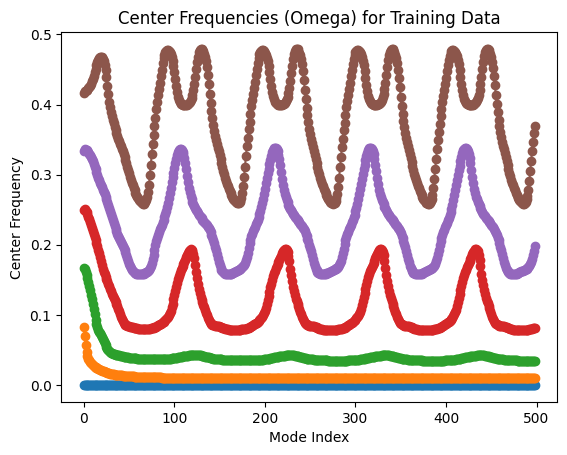

In [74]:
plt.plot(omega_train, marker='o')
plt.title('Center Frequencies (Omega) for Training Data')
plt.xlabel('Mode Index')
plt.ylabel('Center Frequency')
plt.show()


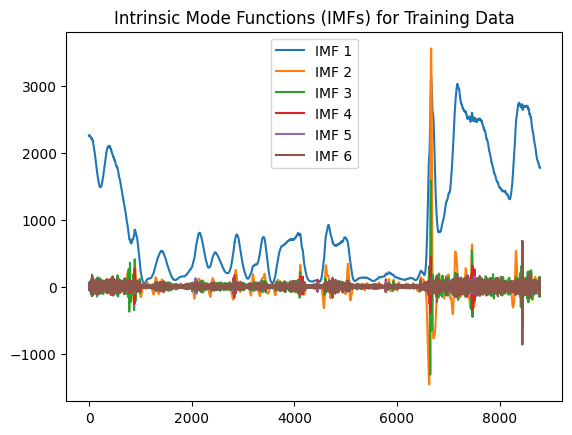

In [73]:
import matplotlib.pyplot as plt

for i in range(K):  # K is the number of modes
    plt.plot(u_train[:, i], label=f'IMF {i+1}')

plt.title('Intrinsic Mode Functions (IMFs) for Training Data')
plt.legend()
plt.show()


In [ ]:
u_train = u_train.T


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming u_train is your input data with shape (6, 8784)
# Transpose the data to have the time series in the correct dimension

# Extract the 'Streamflow' column as your target variable
target_variable = df.loc[df.index >= '2020-04-11', 'Streamflow'].values[1:]

# Split the data into input (X) and output (y)
X = u_train[:-1, :]  # Use all but the last time step as input
y = target_variable   # 'Streamflow' is your target variable

# Reshape the input data to be 3D [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X.shape[1], 1)))
model.add(Dense(units=1))  # Output layer with 1 unit for the target variable

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)


**Gives good approximations on smaller streamflow values**

275/275 [==============================] - 1s 3ms/step


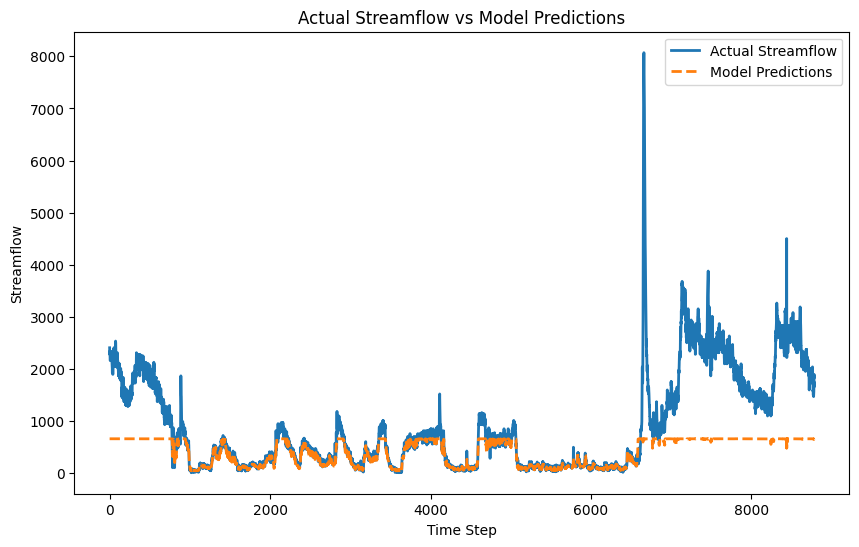

In [72]:
import matplotlib.pyplot as plt

# Make predictions using the trained model
predictions = model.predict(X)

# Plot the actual 'Streamflow' values and the model predictions
plt.figure(figsize=(10, 6))
plt.plot(target_variable, label='Actual Streamflow', linewidth=2)
plt.plot(predictions, label='Model Predictions', linestyle='--', linewidth=2)
plt.title('Actual Streamflow vs Model Predictions')
plt.xlabel('Time Step')
plt.ylabel('Streamflow')
plt.legend()
plt.show()
